In [1]:
import numpy as np
import scipy
import scipy.optimize
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy import stats
import scipy.stats
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
import glob
import time
import pandas as pd
import math
plt.rcParams["figure.figsize"] = (3,3)



print (time.ctime())

Tue Feb 23 16:09:45 2021


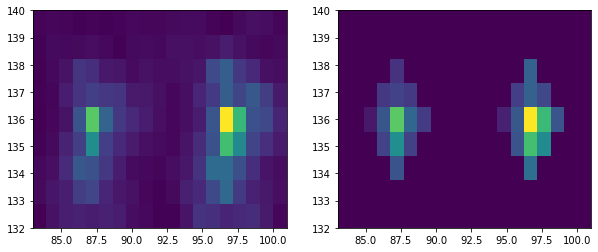

In [30]:
### Call the modules that have both the File information and the functions to perform the analysis ###
import Ion_functions as func
from Ion_functions import Ion
import choose_file 
choose_file.Jumps_Two_100s_2(True) #file selection, plots ROI's to verify number and location of Ions. 

Ion 1 threshold: 9.99e-03(s)
Bright events (#/%): 16742 / 93.96% 

Ion 2 threshold: 9.93e-03(s)
Bright events (#/%): 25882 / 96.54% 

Ion 3 does not exist.
Ion 4 does not exist.
Ion 5 does not exist.
Ion 6 does not exist.


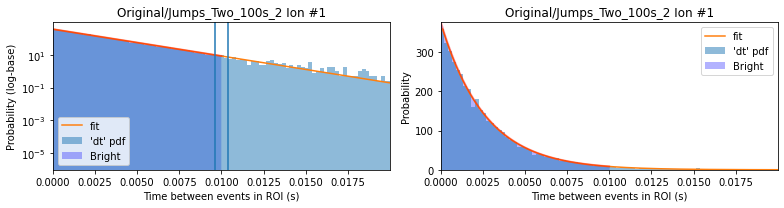

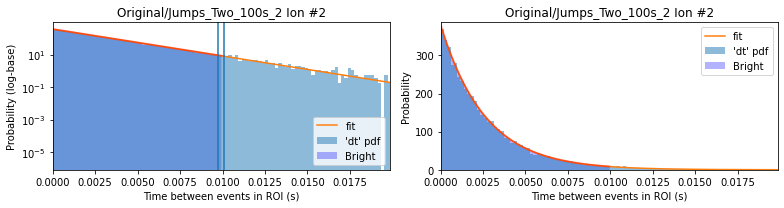

In [31]:
ion_1 = choose_file.ion_1
ion_2 = choose_file.ion_2
ion_3 = choose_file.ion_3
ion_4 = choose_file.ion_4
ion_5 = choose_file.ion_5
ion_6 = choose_file.ion_6
Ion_1 = choose_file.Ion_1
Ion_2 = choose_file.Ion_2
Ion_3 = choose_file.Ion_3
Ion_4 = choose_file.Ion_4
Ion_5 = choose_file.Ion_5
Ion_6 = choose_file.Ion_6

filename = choose_file.filename
old_data_table = choose_file.old_data_table
data_table = choose_file.data_table

sigma = 2
uncertainty = True
single_photon = False
ion_1.setup(sigma, uncertainty, single_photon)
ion_2.setup(sigma, uncertainty, single_photon)
ion_3.setup(sigma, uncertainty, single_photon)
ion_4.setup(sigma, uncertainty, single_photon)
ion_5.setup(sigma, uncertainty, single_photon)
ion_6.setup(sigma, uncertainty, single_photon)

# Correlation Matrix (Bright/Dark States)

In [27]:
#Define begining and end of the integration in order to allow every ion to have indexable data throughout the loop. 

end = min(np.array([max(Ion_1['index']), max(Ion_2['index'])]))#, max(Ion_3['index']), max(Ion_4['index'])]))
start = max(np.array([min(Ion_1['index']), min(Ion_2['index'])]))#, min(Ion_3['index']), min(Ion_4['index'])]))
duration = end-start

#set up arrays to be appended. 
a = []
b = [] 
c = []
d = []

#for every point along the ingegration path, append whether the previous hit was in the bright or dark state
for i in np.arange(start, end, duration/1e5):      
    # append state value to the data frame as 1 or -1
    a.append(Ion_1.at[func.find_nearest(Ion_1['index'], i), 'B/D'])
    b.append(Ion_2.at[func.find_nearest(Ion_2['index'], i), 'B/D'])
    c.append(Ion_3.at[func.find_nearest(Ion_3['index'], i), 'B/D'])
    d.append(Ion_4.at[func.find_nearest(Ion_4['index'], i), 'B/D'])

# put it all into a pandas dataframe to determine the correlation matrix
setup = {'Ion_1': [], 'Ion_2': [], 'Ion_3': [], 'Ion_4': []}
df = pd.DataFrame(data=setup)

df['Ion_1'] = a
df['Ion_2'] = b
df['Ion_3'] = c
df['Ion_4'] = d

import seaborn as sn  

# determine the correlation matrix of the dataframe
correlation = df.corr()
plt.matshow(correlation, vmax = .05, vmin = -.05, cmap = 'seismic')
plt.colorbar()
correlation




AttributeError: 'list' object has no attribute 'at'

# Correlation Matrix (Bright/Dark Transitions)

,Ion_1,Ion_2,Ion_3,Ion_4
Ion_1,1.000000,0.001507,-0.005582,0.009093
Ion_2,0.001507,1.000000,0.001983,-0.000121
Ion_3,-0.005582,0.001983,1.000000,0.005502
Ion_4,0.009093,-0.000121,0.005502,1.000000


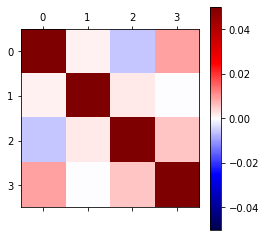

In [5]:
#Define begining and end of the integration in order to allow every ion to have indexable data throughout the loop. 

end = min(np.array([max(Ion_1['index']), max(Ion_2['index']), max(Ion_3['index']), max(Ion_4['index']), max(Ion_5['index']), max(Ion_6['index'])]))
start = max(np.array([min(Ion_1['index']), min(Ion_2['index']), min(Ion_3['index']), min(Ion_4['index']), min(Ion_5['index']), min(Ion_6['index'])]))
duration = end-start

#set up arrays to be appended. 
a = []
b = [] 
c = []
d = []

#for every point along the ingegration path, append whether the previous hit was in the bright or dark state
for i in np.arange(start, end, duration/1e5):      
    # append state value to the data frame as 1 or -1
    a.append(Ion_1.at[func.find_nearest(Ion_1['index'], i), 'B/D'])
    b.append(Ion_2.at[func.find_nearest(Ion_2['index'], i), 'B/D'])
    c.append(Ion_3.at[func.find_nearest(Ion_3['index'], i), 'B/D'])
    d.append(Ion_4.at[func.find_nearest(Ion_4['index'], i), 'B/D'])

# put it all into a pandas dataframe to determine the correlation matrix
setup = {'Ion_1': [], 'Ion_2': [], 'Ion_3': [], 'Ion_4': []}
df = pd.DataFrame(data=setup)

df['Ion_1'] = a
df['Ion_2'] = b
df['Ion_3'] = c
df['Ion_4'] = d

import seaborn as sn  

# determine the correlation matrix of the dataframe
correlation = df.corr()
plt.matshow(correlation, vmax = .05, vmin = -.05, cmap = 'seismic')
plt.colorbar()
correlation




2168

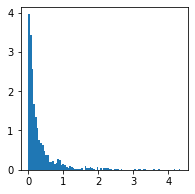

In [15]:
def idx_to_time(index_array, table_with_times):
    needed = []
    for i in index_array:
        needed.append(table_with_times.at[i, 'time'])
    return needed

def transitions_to_times(ion_object, DtB = False, BtD = False):
    if DtB:
        needed = []
        for i in ion_object.DtB:
            needed.append(ion_object.data.at[i, 'time'])
        return needed
    
    elif BtD:
        needed = []
        for i in ion_object.BtD:
            needed.append(ion_object.data.at[i, 'time'])
        return needed
    
    else:
        needed = []
        for i in ion_object.transpts:
            needed.append(ion_object.data.at[i, 'time'])
        return needed
    
times_1 = transitions_to_times(ion_3)
times_2 = transitions_to_times(ion_4)
tdifference = []
time_max = min([times_1[-2], times_2[-2]])
for i in times_1:
    if i > time_max:
        break
    else:
        if times_2[(np.searchsorted(times_2, i))+1] - i != 0:
            tdifference.append(times_2[(np.searchsorted(times_2, i))+1] - i)
plt.hist(tdifference, bins = 'auto', density = True)
len(tdifference)

In [28]:
def transition_differences(object_1, object_2):
    times_1 = transitions_to_times(object_1)
    times_2 = transitions_to_times(object_2)
    tdifference = []
    time_max = min([times_1[-2], times_2[-2]])
    
    for i in times_1:
        if i > time_max:
            break
        else:
            if times_2[(np.searchsorted(times_2, i))+1] - i != 0:
                tdifference.append(times_2[(np.searchsorted(times_2, i))+1] - i)
    ax.hist(tdifference, bins = 'auto', histtype = 'step', label = (f'{object_1.n} to {object_2.n}'))
    
def transition_differences_full(object_1, DtB = False, BtD = False):
    fig, (ax, ax2) = plt.subplots(ncols = 2, figsize = (15, 4))
    ions = [ion_1, ion_2]#, ion_3]#, ion_4]#, ion_5, ion_6]
    times_1 = transitions_to_times(object_1, DtB, BtD)
    for i in range(len(ions)):
        object_2 = ions[i]
        #if object_2 == object_1:
        #    continue
        times_2 = transitions_to_times(object_2)
        tdifference = []
        time_max = min([times_1[-2], times_2[-2]])
        used = []
        
        for j in range(len(times_1)):
            if times_1[-j] > time_max:
                continue
            else:
                if times_2[(np.searchsorted(times_2, times_1[-j]))+1] not in used: #times_2[(np.searchsorted(times_2, times_1[-j]))+1] - times_1[-j] != 0 and 
                    used.append(times_2[(np.searchsorted(times_2, times_1[-j]))+1])
                    tdifference.append(times_2[(np.searchsorted(times_2, times_1[-j]))+1] - times_1[-j])
        print(len(tdifference))
        bin_heights, bin_borders, _ = ax.hist(tdifference, bins = 30, histtype = 'step', range = (0,.4), label = (f'{object_1.n} to {object_2.n}'), density = True)
        bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
        ax2.plot(bin_centers, bin_heights, label = (f'{object_1.n} to {object_2.n}'))
        ax.set_xlabel(f'time from transition in Ion #{object_1.n} and transition in reference ion')
        ax2.set_xlabel(f'time from transition in Ion #{object_1.n} and transition in reference ion')
        ax2.legend()
        ax.legend()
        #ax.set_yscale('log')
        


1639
575
574
1531


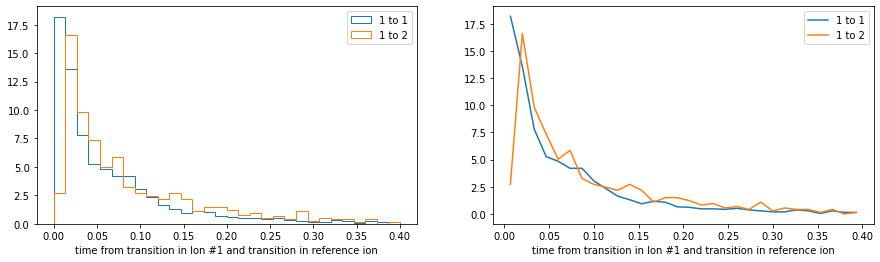

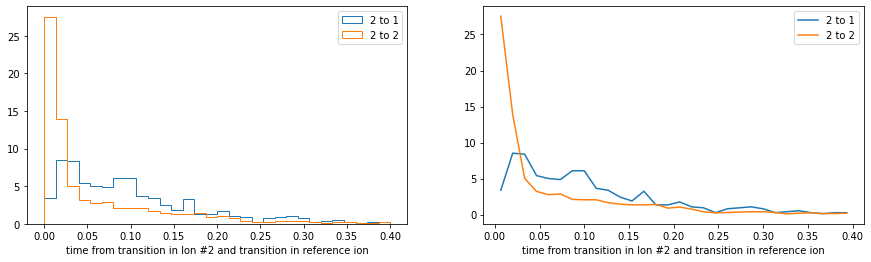

In [32]:
transition_differences_full(ion_1, BtD = False)
transition_differences_full(ion_2, BtD = False)
#transition_differences_full(ion_3, BtD = False)
#transition_differences_full(ion_4, BtD = False)
#transition_differences_full(ion_5, BtD = False)
#transition_differences_full(ion_6, BtD = False)

In [99]:
mark = 1
duration = 2e-7
array_11, x11, y11 = afterpulse_elements(ion_1.data, ion_1.data, duration, same = True)
array_12, x12, y12 = afterpulse_elements(ion_1.data, ion_2.data, duration,)
array_13, x13, y13 = afterpulse_elements(ion_1.data, ion_3.data, duration,)
array_14, x14, y14 = afterpulse_elements(ion_1.data, ion_4.data, duration,)
array_22, x22, y22 = afterpulse_elements(ion_2.data, ion_2.data, duration, same = True)
array_23, x23, y23 = afterpulse_elements(ion_2.data, ion_3.data, duration,)
array_24, x24, y24 = afterpulse_elements(ion_2.data, ion_4.data, duration,)
array_33, x33, y33 = afterpulse_elements(ion_3.data, ion_3.data, duration, same = True)
array_34, x34, y34 = afterpulse_elements(ion_3.data, ion_4.data, duration,)
array_44, x44, y44 = afterpulse_elements(ion_4.data, ion_4.data, duration, same = True)

done [1] || length: 262
done [2] || length: 127
done [3] || length: 35
done [4] || length: 15
done [5] || length: 300
done [6] || length: 250
done [7] || length: 50
done [8] || length: 454
done [9] || length: 200
done [10] || length: 286


In [100]:
afterpulse_correlation = np.array([np.array([len(array_11), len(array_12), len(array_13), len(array_14)]), 
                                                 np.array([0, len(array_22), len(array_23), len(array_24)]),
                                                             np.array([0, 0, len(array_33), len(array_34)]), 
                                                                         np.array([0, 0, 0, len(array_44)])])
afterpulse_correlation

array([[262, 127,  35,  15],
       [  0, 300, 250,  50],
       [  0,   0, 454, 200],
       [  0,   0,   0, 286]])

In [101]:

def expected_count(data, duration):
    count = len(data)/(data['time'].max() - data['time'].min())
    return count
    
np.array([expected_count(Ion_1, duration), expected_count(Ion_2, duration),
          expected_count(Ion_3, duration), expected_count(Ion_4, duration)])

array([338.4799495 , 439.88905939, 549.86478107, 414.4976734 ])

Text(0.5, 0.98, 'After Pulsing Effect +-200ns')

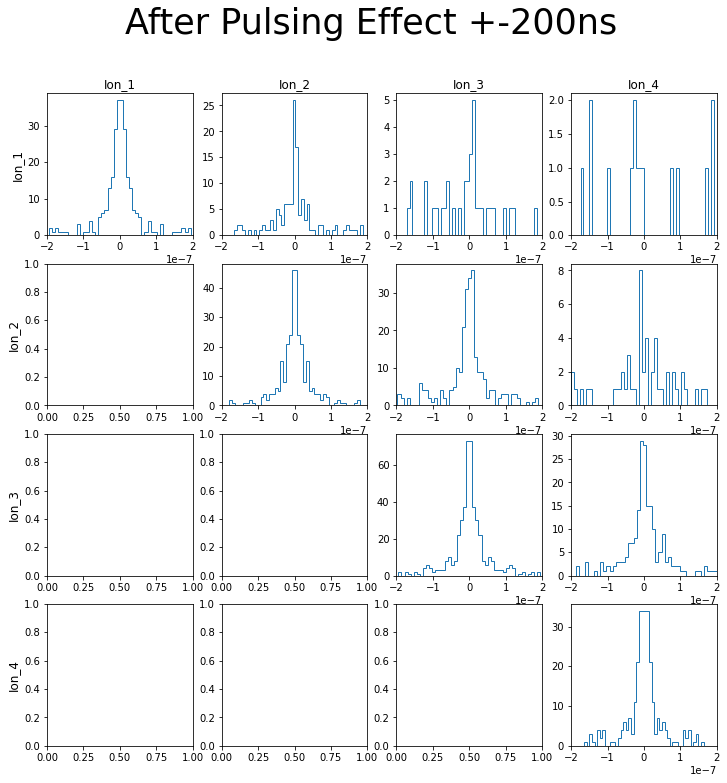

In [102]:
fig, ([ax11, ax12, ax13, ax14], [ax21, ax22, ax23, ax24],
      [ax31, ax32, ax33, ax34], [ax41, ax42, ax43, ax44])= plt.subplots(ncols= 4, nrows = 4, figsize = (12,12))
bins = 46
ax11.hist(array_11, bins = bins, histtype = 'step'); ax11.set_xlim(-duration, duration); ax11.set_title('Ion_1')
ax12.hist(array_12, bins = bins, histtype = 'step'); ax12.set_xlim(-duration, duration); ax12.set_title('Ion_2')
ax13.hist(array_13, bins = bins, histtype = 'step'); ax13.set_xlim(-duration, duration); ax13.set_title('Ion_3')
ax14.hist(array_14, bins = bins, histtype = 'step'); ax14.set_xlim(-duration, duration); ax14.set_title('Ion_4')
ax22.hist(array_22, bins = bins, histtype = 'step'); ax22.set_xlim(-duration, duration)
ax23.hist(array_23, bins = bins, histtype = 'step'); ax23.set_xlim(-duration, duration)
ax24.hist(array_24, bins = bins, histtype = 'step'); ax24.set_xlim(-duration, duration)
ax33.hist(array_33, bins = bins, histtype = 'step'); ax33.set_xlim(-duration, duration)
ax34.hist(array_34, bins = bins, histtype = 'step'); ax34.set_xlim(-duration, duration)
ax44.hist(array_44, bins = bins, histtype = 'step'); ax44.set_xlim(-duration, duration)
ax11.set_ylabel('Ion_1', fontsize = 12)
ax21.set_ylabel('Ion_2', fontsize = 12)
ax31.set_ylabel('Ion_3', fontsize = 12)
ax41.set_ylabel('Ion_4', fontsize = 12)
fig.suptitle('After Pulsing Effect +-200ns', fontsize = 35)
